# Spam or Ham Classifier Using NLP!

**Context**
- Data is collected from the UCI datasets..
- The file we are using contains a collection of more than 5 thousand SMS phone messages. 

**AIM**
- To design a system to correctly classify Spam or Ham based on the text message.
- To design a simple and yet efficient system.

## Importing Libraries

In [2]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [29]:
#Reading the data file
df = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])

In [30]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#Finding the length fo the file
lines=[lines for lines in open('smsspamcollection/SMSSpamCollection')]
print(len(lines))

5574


In [31]:
#Sample messages
for i,mes in enumerate(lines[:5]):
    print(i,mes)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



1 ham	Ok lar... Joking wif u oni...



2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



3 ham	U dun say so early hor... U c already then say...



4 ham	Nah I don't think he goes to usf, he lives around here though





- Example Messages are shown above, Spam are usally the promotional messages or offers.
- Ham or the usual mails someone sends to other person

In [32]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [33]:
#Let's Create a new Column Based on the length of the Messages
df['length']=df['message'].apply(len)

In [34]:
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [35]:
df.groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

- There are 4825 ham messages and 747 spam messages.
- There is a ham message of length 910 insane.
- Highest spam message is 223 words.

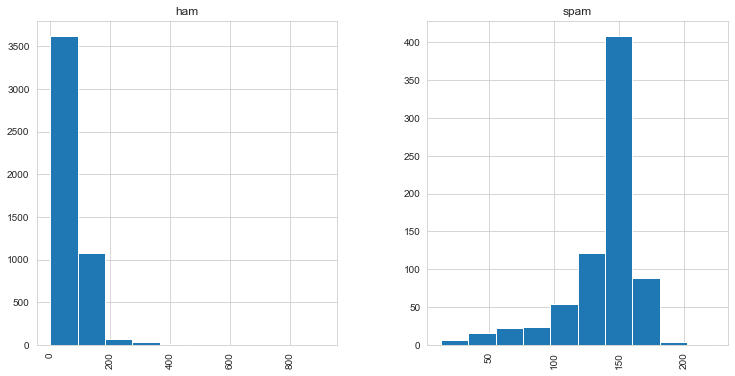

In [12]:
#lets perform some viusalizations on our DataFrame
df.hist(column='length',by='label',figsize=(12,6));

- Its Obvious that Most of the Spam Messages are of More length

In [14]:
#Checking the longest message
#opps! it is Lover Letter lol!!
df[df['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

# Text Preprocessing

- Initial step is to remove punctucations as they don't contain any information in the message.
- Then the stop words are removed, because they also of less use.


In [36]:
import string
#Punctuation are not Much useful interms of training a model because it doesn't convey any meaning!!
df['message'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

### Removing Punctuations

In [40]:
#let's Remove Punctuations
stop_wrds=[i for i in df['message'][0] if i not in string.punctuation]
stop_wrds="".join(stop_wrds)
stop_wrds

'Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat'

### Removing Stop Words

In [42]:
#Punctutations are removed Now Let's Remove Stop Words because those stop words are not gonna convey Any Meaning!!s
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [43]:
#Lets do it For one message
stop_wrds=[wrds for wrds in stop_wrds.split() if wrds.lower() not in stopwords.words('english') ]
" ".join(stop_wrds)

'Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat'

- Bam Stop Words are Removed

In [44]:
#Now Lets Apply this to to out entire Data
def text_process(mess):
    #Removing Punctuations
    non_punc=[ i for i in mess if i not in string.punctuation]
    non_punc="".join(non_punc)
    #Removing Stop Words
    return([wrd for wrd in non_punc.split() if wrd not in stopwords.words('english')])

In [45]:
proc_mes=df['message'].apply(text_process)

In [46]:
proc_mes.shape

(5572,)

# Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer(analyzer=text_process)
vect_data=vect.fit_transform(df['message'])

In [48]:
vect_data.shape

(5572, 11617)

Contains Large no.of Vector in which most of the data is of 0's

Lets Claculate TF-IDF values..!!

### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*,
**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*


In [49]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf=tfidf_transformer.fit_transform(vect_data)
print(tfidf)

  (0, 11355)	0.23026685592418913
  (0, 11157)	0.19073428545061483
  (0, 9109)	0.24704652376837993
  (0, 8528)	0.17046869292195632
  (0, 7860)	0.26403384065473806
  (0, 7747)	0.3125385626069455
  (0, 7129)	0.1834692413608692
  (0, 7098)	0.15158474664662352
  (0, 6409)	0.18915557732842803
  (0, 5961)	0.24984711892976424
  (0, 5410)	0.2687059386252667
  (0, 5409)	0.29835184088197164
  (0, 4845)	0.3125385626069455
  (0, 2113)	0.24203960256420656
  (0, 1521)	0.3125385626069455
  (0, 1133)	0.2882862016308418
  (1, 11264)	0.4006156098244305
  (1, 10890)	0.20636374813230077
  (1, 8782)	0.5043405901305853
  (1, 7893)	0.37674010708127936
  (1, 3177)	0.2911995411244838
  (1, 2535)	0.561988811929381
  (2, 11315)	0.1910438722050911
  (2, 11276)	0.1589814534717675
  (2, 10878)	0.13995540820792943
  :	:
  (5568, 4502)	0.37279231516513645
  (5569, 10391)	0.520467167163554
  (5569, 8444)	0.43282997090570735
  (5569, 3852)	0.520467167163554
  (5569, 3349)	0.520467167163554
  (5570, 11198)	0.199005018314

Now let's Convert the Categorical Value to Numerical Value!1

In [50]:
y=pd.get_dummies(df['label'],drop_first=True)
y.head()

,spam
0,0
1,0
2,1
3,0
4,0


In [51]:
X=tfidf

# Now Let's Split the data and Train the Model

In [52]:
#Splitting the data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [53]:
#Multinomial Naive Bayes Model.
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB()
spam_detect_model.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB()

In [54]:
#Predicting the test set
pred=spam_detect_model.predict(X_test)

In [55]:
#Getting the accuracy
spam_detect_model.score(X_train,y_train)

0.9691936780069649

In [56]:
#Printing the classification report
from sklearn.metrics import classification_report,confusion_matrix
print (classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1593
           1       1.00      0.71      0.83       246

    accuracy                           0.96      1839
   macro avg       0.98      0.85      0.90      1839
weighted avg       0.96      0.96      0.96      1839



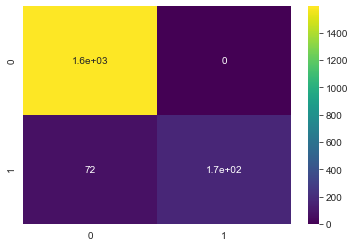

In [58]:
#Heatmap
sns.heatmap(confusion_matrix(y_test,pred),annot=True,cmap='viridis');

# Pipelines

- The entire process can be automated using pipeline function from sklearn.
- The pipeline function makes the work much easier.

In [59]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(df['message'], df['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [60]:
#Defining the pipeline to performe sequence of events
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [61]:
#Fitting Using Pipeline
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f7ee4cf2a60>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [62]:
predictions = pipeline.predict(msg_test)

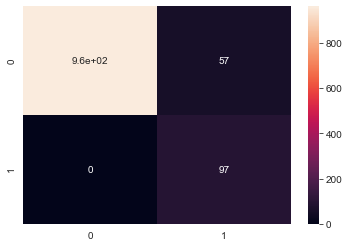

In [64]:
sns.heatmap(confusion_matrix(predictions,label_test),annot=True);

In [65]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.94      0.97      1018
        spam       0.63      1.00      0.77        97

    accuracy                           0.95      1115
   macro avg       0.81      0.97      0.87      1115
weighted avg       0.97      0.95      0.95      1115



# Thank You!!